<p style="font-family: Arial; font-size:2.75em;color:purple; font-style:bold"><br>
UK Retails: A Data Science Case Study</p><br>

**Applicant:** Yasar Qamar

**Project:** Predictive Regression Algorithm implemented in Python. 

<h1 style="font-size:2em;color:#2467C0">Solution Outline</h1>
</p>
<br>
In this notebook, a predictive model has been built that explains the **'Revenue of next order for any customer'**.
<br>

I have used a Regression model as the Machine Learning model for this task. It is built using the *sklearn* Python library. Other Python libraries used extensively in this task are *Numpy, Pandas, Scipy* and *Math*.

I have used R for Data Visualisation in this notebook using *ggplot2*. All R code is also written in this notebook by using the *rpy2* interface to R from Python. I have chosen this interface as Jupyter allows R code to be written in the same notebook running a Python Kernel and, also, because Python *data frames* can be easily imported to R *data frames* using *rpy2*.

The dataset provided for this task is the following CSV file:
* **UKretail.csv :** *InvoiceNo*,*StockCode*,*Description*, *Quantity*, *InvoiceDate*, *UnitPrice*, *CustomerID*, *Country*

The solution methodology can be divided into following broad categories:

* **Data Ingestion:** Using Pandas the CSV file is read and stored into a DataFrame.
* **Data Cleaning:** Entries considered to be invalid are removed, e.g. missing values (NaN), negative values, etc.
* **Data Exploration:** A brief overview of data is considered, e.g. mean, median, quartiles and outliers.
* **Data Selection:** Further data pruning is done based on quartiles to reduce the number of outliers in the data.
* **Machine Learning Model** Data is divided into training and testing parts. A Regression model is applied and predictions are obtained.
* **Model Validation:** The prediction errors are examined using some common metrics. Justification for the obtained results is provided.

<h1 style="font-size:2em;color:#2467C0">Import Libraries</h1>


In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from scipy import stats
from scipy.stats import mstats
import scipy

from math import sqrt
from math import fabs

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext rpy2.ipython
%R require(ggplot2)
%R require(gridExtra)


array([1], dtype=int32)

<h1 style="font-size:2em;color:#2467C0">Data Ingestion</h1>


In [2]:
# Using Pandas to read dataset
retails = pd.read_csv('UKretail.csv', sep=',', encoding = "ISO-8859-1")

# To check the data type
print(type(retails))

<class 'pandas.core.frame.DataFrame'>


In [3]:
# To get a quick view of the first 10 dataset entries
retails.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:02,7.65,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:02,3.39,17850.0,United Kingdom
2,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:02,3.39,17850.0,United Kingdom
3,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:02,2.55,17850.0,United Kingdom
4,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:02,1.85,17850.0,United Kingdom
5,536367,21754,HOME BUILDING BLOCK WORD,3,2010-12-01 08:33:59,5.95,13047.0,United Kingdom
6,536367,21755,LOVE BUILDING BLOCK WORD,3,2010-12-01 08:33:59,5.95,13047.0,United Kingdom
7,536367,21777,RECIPE BOX WITH METAL HEART,4,2010-12-01 08:33:59,7.95,13047.0,United Kingdom
8,536367,22310,IVORY KNITTED MUG COSY,6,2010-12-01 08:33:59,1.65,13047.0,United Kingdom
9,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:33:59,2.10,13047.0,United Kingdom


In [4]:
# To check the number of Rows and Number of Columns in the dataset
retails.shape

(325145, 8)

In [5]:
# To check the variables contained in the dataset
retails.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

<h1 style="font-size:2em;color:#2467C0">Data Cleaning and Exploratory Data Analysis</h1>

First lets take a quick look at how the *Quantity* and *UnitPrice* entries are distributed. This will point out if the miminum and/or maximum values are in the valid range or not. The values in the *CustomerID* column are irrelevant for this purpose.

In [6]:
# to get statistics of the Quantity and UnitPrice columns of the dataset
retails.describe()

,Quantity,UnitPrice,CustomerID
count,325145.000000,325145.000000,244154.000000
mean,9.273340,4.845239,15288.823120
std,154.394112,116.830451,1713.496816
min,-80995.000000,-11062.060000,12347.000000
25%,1.000000,1.250000,13959.000000
50%,3.000000,2.080000,15150.000000
75%,10.000000,4.130000,16792.750000
max,12540.000000,38970.000000,18287.000000


**Remarks:** It can be easily seen from above that the Quanity and UnitPrice columns contain some invalid data entries as pointed out by the negative values.

Now I am going to check for the missing values in the dataset

In [7]:
# to check if any row in the DataFrame contains a missing value, also referred to as Null or NaN in Python.
retails.isnull().any()

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

**Remarks:** There are NULL values in the *Description* and *CustomerID* columns. The missing values for *CustomerID* cannot be imputed by taking the mean or some other measure of the values in the column. This is because of the inherent nature of the dataset and it will be bad for the model if fictitous values for *CustomerID* are used. As a result the only option to fix these missing values is to drop all the rows that contain missing values for the *CustomerID* column. 

In [8]:
# to create a copy of the DataFrame so that original DataFrame is preserved in case it is needed later.
test = retails.copy()

# No. of rows in original dataset
b_remove = test.shape

# to remove the missing values
test = test.dropna()

# No. of rows in dataset after removing missing values
a_remove = test.shape

# to display the No. of rows dropped
print("Number of Rows dropped =", b_remove[0] - a_remove[0])

Number of Rows dropped = 80991


In [9]:
# to check if the dataset has any missing values in any column
test.isnull().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
Country        False
dtype: bool

**Remarks:** As can be seen above, there are no more missing values in the dataframe..<br> <br> 
Now the next step is to check for invalid data entries in the dataset. 
This means that negative values in the *Quantity* column do not make sense as it is physically not possible in the real world to buy a negative quantity of items. Possible options to fix these values is to either assign them a value of zero, impute them with the mean of the column or to drop them. I have decided to drop these values. This is because assigning them zero value will not contribute to the revenue and is hence useless, and also imputing them with the mean value is not a good choice as it is not representative for all the customers.

The negative values in the *UnitPrice* column indicate a cancelled order. It makes sense to drop these as well since they will also not contribute to the revenue generated for each customer per transaction.  

In [10]:
# to create a filter for positive values of Quantity
is_positive_value_1 = test['Quantity'] > 0.0

# to create a filter for positive values of UnitPrice
is_positive_value_2 = test['UnitPrice'] >= 0.1

# to apply the 2 filters and store in new dataframe 
test_positive_values = test[is_positive_value_1 & is_positive_value_2]

# to get summary statistics of the new dataframe
test_positive_values.describe()

,Quantity,UnitPrice,CustomerID
count,238616.000000,238616.000000,238616.000000
mean,12.533078,3.132172,15295.360085
std,43.252664,25.303354,1713.144643
min,1.000000,0.100000,12347.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15157.000000
75%,12.000000,3.750000,16800.000000
max,4800.000000,8142.750000,18287.000000


In [11]:
# to check for total No. of Unique Customers in Database.
test_positive_values['CustomerID'].value_counts().size

4290

**Remarks:** The values for *Quantity* and *UnitPrice* columns are all positive!

<h1 style="font-size:2em;color:#2467C0">Data Exploration</h1>

First, I am going to visualise the data obtained thus far. Based on this I will decide if further steps need to be taken to improve the data. <br>

*Note:* Here, and as for all the visualisations to follow in this notebook, I have used the R libraries *ggplot2, grid* and *gridExtra*. These will be needed in order to run the R code in this notebook. 

In [12]:
# to check the Path of the R library from where Anaconda is accessing R libraries. Make sure the required libraries are contained in this Path.
from rpy2.robjects.packages import importr
base = importr('base')
print(base.R_home())
print(base._libPaths())


[1] "E:/PythonAnaconda/R"

[1] "E:/PythonAnaconda/R/library"



In [17]:
%%R -i test_positive_values

#to interface R with Python and create an R dataframe of the same name
#library(ggplot2)
#require(ggplot2)

#library(grid)
#require(grid)

# to plot a Scatter Plot of Quantity against CustomerID
ggplot(test_positive_values, aes(x=CustomerID, y=Quantity, color=CustomerID)) + geom_point()

**Remarks:** It can be seen that the *Quantity* values contain some Outliers. Majority of the values are less than 1000.

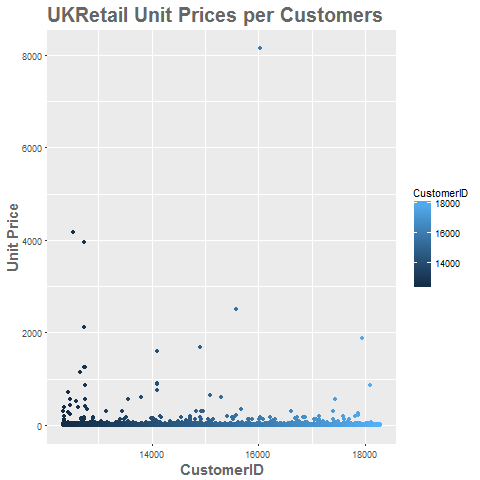

In [930]:
%%R
#to interface R with Python and create an R dataframe of the same name

# to plot a Scatter Plot of Quantity against CustomerID
ggplot(test_positive_values, 
       aes(x=CustomerID, y=UnitPrice, color=CustomerID)) + 
    geom_point() + 
    ggtitle("UKRetail Unit Prices per Customers") +
    labs(x="CustomerID",y="Unit Price") + 
    theme(plot.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=20, hjust=0)) +
    theme(axis.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=15))

#library(gridExtra)
#require(gridExtra)
#grid.arrange(p1, p2, ncol=2, widths= 2)

**Remarks:** It can be seen that the *UnitPrice* values contain some Outliers. Majority of the values are very small in magnitude.

These Outliers need to be removed. Since the values for UnitPrice seems to be much smaller in magnitude, I am going to keep only the values for *UnitPrice* and *Quantity* that are less than the 90% percentile of values for the respective Columns. 

In [18]:
# to get the 90% percentile value for UnitPrice
test_positive_values.UnitPrice.quantile(.90)

6.35

In [19]:
# to get the 95% percentile value for Quantity
test_positive_values.Quantity.quantile(.95)

36.0

In [20]:
# to make a copy of the dataframe so far
tpv = test_positive_values.copy()

# to create a filter based on lesser than 90% percentile of UnitPrice values
in_std_UP = tpv['UnitPrice'] <= test_positive_values.UnitPrice.quantile(.90)

# to create a filter based on lesser than 95% percentile of Quantity values
in_std_QTY = tpv['Quantity'] <= test_positive_values.Quantity.quantile(.95)

# to apply the 2 filters and store in new dataframe
tpv_in_std = tpv[in_std_QTY & in_std_UP]

In [21]:
# to get summary statistics
tpv_in_std.describe()


,Quantity,UnitPrice,CustomerID
count,203464.000000,203464.000000,203464.000000
mean,7.968412,2.108118,15322.717414
std,7.570649,1.441610,1712.234637
min,1.000000,0.100000,12347.000000
25%,2.000000,1.060000,13988.000000
50%,6.000000,1.650000,15237.000000
75%,12.000000,2.950000,16818.000000
max,36.000000,6.350000,18287.000000


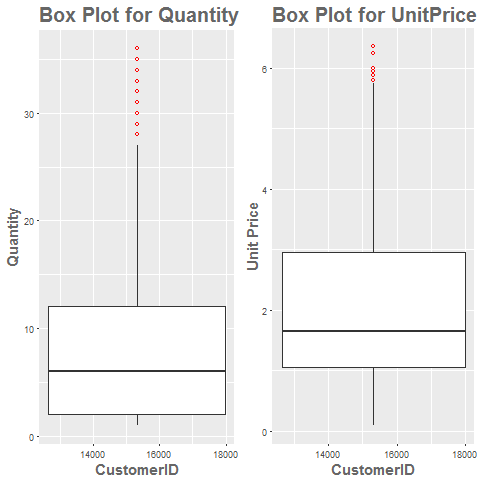

In [955]:
%%R -i tpv_in_std
# to interface R to Python

# to plot a BoxPlot of Quantity against CustomerID
p1 <- ggplot(tpv_in_std, aes(x = CustomerID, y = Quantity)) +
  geom_boxplot(outlier.colour = "red", outlier.shape = 1) +
  ggtitle("Box Plot for Quantity") +
  labs(x="CustomerID",y="Quantity") + 
  theme(plot.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=20, hjust=0)) +
  theme(axis.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=15))

# to plot a BoxPlot of UnitPrice against CustomerID
p2 <- ggplot(tpv_in_std, aes(x = CustomerID, y = UnitPrice)) +
  geom_boxplot(outlier.colour = "red", outlier.shape = 1) +
  ggtitle("Box Plot for UnitPrice") +
  labs(x="CustomerID",y="Unit Price") + 
  theme(plot.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=20, hjust=0)) +
  theme(axis.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=15))


# to create a Multi-plot of the above Box Plots using the R-library gridExtra
library(gridExtra)
require(gridExtra)
grid.arrange(p1, p2, ncol=2)

**Remarks:** The number of Outliers (shown above in Red) for both the Columns have reduced considerably.

To proceed further the revenue of each quantity needs to be calculated. A simple calculation of multiplying the *Quantity* column with *UnitPrice* column yields the desired output. A new column *Revenue* containing these calculated values is added to the DataFrame.

In [22]:
# to make a copy of the dataframe
test_a = tpv_in_std.copy()

# to get the Revenue = Quantity*UnitPrice for each row and store it in a new Column
test_a['Revenue'] = test_a['Quantity']*test_a['UnitPrice']

#to make a new copy of the dataframe
test_b = test_a.copy()

#to drop all the other irrelevant columns of the dataset.
test_b.drop(test_b.columns[[0,1,2,3,4,5,7]], inplace=True, axis=1)

# to check the first 5 rows of the dataset
test_b.head()

,CustomerID,Revenue
1,17850.0,20.34
2,17850.0,20.34
3,17850.0,15.30
4,17850.0,11.10
5,13047.0,17.85


In [23]:
# to get summary statistics
test_b.describe([0.05, 0.25, 0.50, 0.75, 0.95])

,CustomerID,Revenue
count,203464.000000,203464.000000
mean,15322.717414,13.005671
std,1712.234637,13.811547
min,12347.000000,0.120000
5%,12647.000000,1.250000
25%,13988.000000,3.800000
50%,15237.000000,10.080000
75%,16818.000000,17.400000
95%,17920.000000,35.400000
max,18287.000000,225.000000


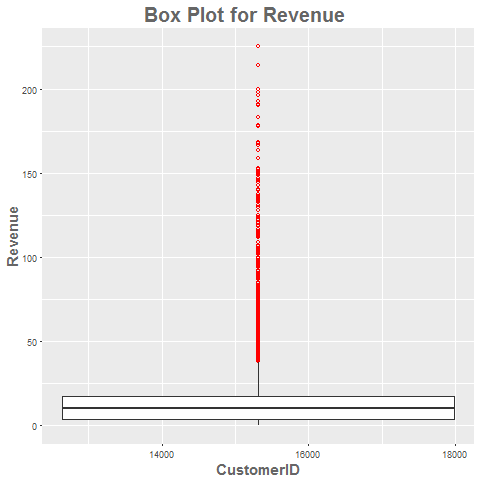

In [967]:
%%R -i test_b
# to interface R to Python

# to plot a BoxPlot of Revenue against CustomerID
ggplot(test_b, aes(x = CustomerID, y = Revenue)) +
  geom_boxplot(outlier.colour = "red", outlier.shape = 1) +
  ggtitle("                 Box Plot for Revenue") +
  labs(x="CustomerID",y="Revenue") + 
  theme(plot.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=20, hjust=0)) +
  theme(axis.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=15))

**Remarks:** The Box Plot shows that there exist Outliers in the Data and also that a large part of the data has smaller values. I will again further prune the data using the percentiles approach. The refined data will contain values between the 5% and 95% percentiles. This is because the *test_b* summary statistics above show that the 95% percentile value for *Revenue* is 35.4 which is much smaller than the maximum value of 225.

In [24]:
# to make a copy of dataframe
test_c = test_b.copy()

# to create a filter based on lesser than 90% percentile of Revenue values
percentile_above = test_c['Revenue'] <= test_c.Revenue.quantile(.90)

# to create a filter based on larger than 5% percentile of Revenue values
percentile_below = test_c['Revenue'] >= test_c.Revenue.quantile(.05)

# to apply the 2 filters and store in new dataframe
trimmed_data = test_c[percentile_above & percentile_below]

# to store the new dataframe back
test_b = trimmed_data.copy()

#to get the summary statistics of the trimmed data
test_b.describe()

,CustomerID,Revenue
count,174887.000000,174887.000000
mean,15335.647327,10.189313
std,1706.671782,6.675768
min,12347.000000,1.250000
25%,14009.000000,4.150000
50%,15271.000000,9.900000
75%,16837.000000,15.300000
max,18287.000000,25.200000


**Remarks:** Let's check the Box Plot for a visualisation of the refined data.

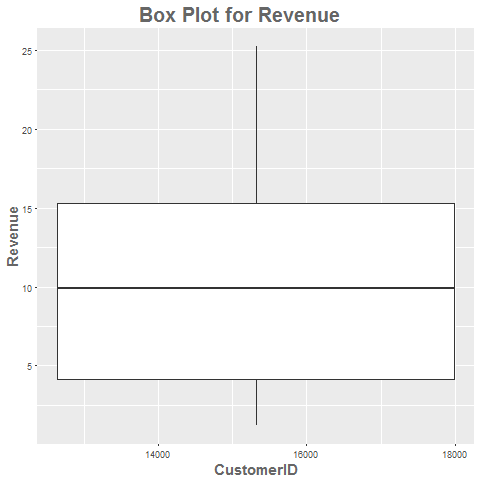

In [969]:
%%R -i test_b
# to interface R to Python

# to plot a BoxPlot of Revenue against CustomerID
ggplot(test_b, aes(x = CustomerID, y = Revenue)) +
  geom_boxplot(outlier.colour = "red", outlier.shape = 1) +
  ggtitle("                 Box Plot for Revenue") +
  labs(x="CustomerID",y="Revenue") + 
  theme(plot.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=20, hjust=0)) +
  theme(axis.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=15))

**Remarks:** The refined data does not contain Outliers anymore.

Returning to the original task, the next step is to group the subsets of rows for each time a separate customer makes an order. This means that the values in the Revenue column have to be summed up to give the total value of the order for every customer. In other words, we need to do a grouping of Orders placed by *CustomerID* and add up the revenue generated per order for each *CustomerID*. <br> <br>
In Pandas this can be done using the *groupby* method.

In [25]:
# to Group in Bunch of Orders placed by CustomerID and adding up Revenue generated per Order for each CustomerID
group_revenue = test_b.groupby(['CustomerID',test_b.CustomerID.diff().ne(0).cumsum()],sort=False)['Revenue'].sum()

#to check the last 5 values
group_revenue.tail()

CustomerID  CustomerID
17581.0     14693         147.40
12748.0     14694          44.80
17581.0     14695          47.22
15804.0     14696         154.41
12680.0     14697         139.85
Name: Revenue, dtype: float64

In [26]:
type(group_revenue)

pandas.core.series.Series

**Remarks:** The *groupby* method takes as input a DataFrame and gives as output a Series

In [27]:
# to convert the Series into a Dataframe
group_revenue_df = group_revenue.reset_index(0).reset_index(drop=True)

#to check the datatype
type(group_revenue_df)

pandas.core.frame.DataFrame

In [28]:
#group_revenue.drop(group_revenue.columns[[0]], inplace=True, axis=1)
group_revenue_df.describe([0.05, 0.99])

,CustomerID,Revenue
count,14697.000000,14697.000000
mean,15264.840852,121.247765
std,1728.182618,114.328953
min,12347.000000,1.250000
5%,12627.800000,15.000000
50%,15159.000000,92.900000
99%,18225.040000,534.446000
max,18287.000000,1823.260000


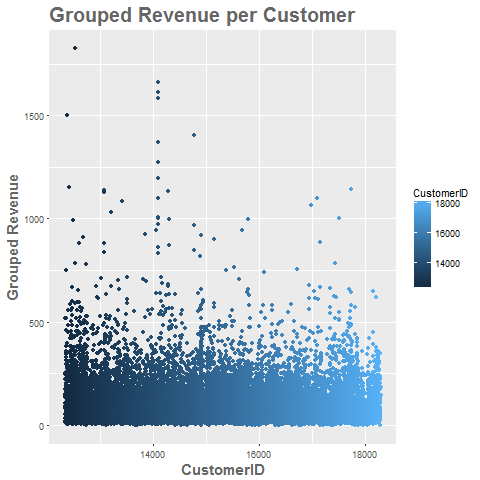

In [979]:
%%R -i group_revenue_df
#to interface R with Python and create an R dataframe of the same name

# to plot a Scatter Plot of Quantity against CustomerID
ggplot(group_revenue_df, 
       aes(x=CustomerID, y=Revenue, color=CustomerID)) + 
    geom_point() + 
    ggtitle("Grouped Revenue per Customer") +
    labs(x="CustomerID",y="Grouped Revenue") + 
    theme(plot.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=20, hjust=0)) +
    theme(axis.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=15))


In [29]:
group_revenue_df.head(10)

,CustomerID,Revenue
0,17850.0,67.08
1,13047.0,100.50
2,12583.0,39.00
3,17850.0,257.00
4,14688.0,174.40
5,15311.0,87.80
6,16098.0,74.60
7,18074.0,17.85
8,17420.0,68.40
9,16250.0,127.80


<h1 style="font-size:2em;color:#2467C0">Machine Learning Model</h1>


To building the Machine Learning Model, I have extracted the *CustomerID* into the X variable and *Revenue* into the target y variable. 
<br><br></p>


In [37]:
# to get the X variable from the Dataframe
X = group_revenue_df['CustomerID']

#to get the y variable from the Dataframe
y = group_revenue_df['Revenue']

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Split the Dataset into Training and Test Datasets
<br><br></p>

The sample and target data are split into 2 groups of test and train data. The ratio of the 2 sets is set to 0.33 and a random state has been specified so that the results can be replicated.

In [38]:
# to split the data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

The train_test_split function returns np arrays. So below I have converted them back to a DataFrame

In [39]:
# to convert the np arrays into Dataframes
X_train = np.array(X_train).reshape((-1, 1))
X_test = np.array(X_test).reshape((-1, 1))
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

(1) Linear Regression: Fit a model to the training set
<br><br></p>

The Machine Learning model chosen for this task is the Linear Regression Model. It is one of the most common regression algorithms to predict numerical values. The drawback is that it is a very basic and simple ML model and may not be very accurate for complex datasets.


In [40]:
# to get the Linear Regressor Model
regressor = LinearRegression()

# to train the Model with our training data
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Perform Prediction using Linear Regression Model
<br><br></p>

Now that the model has been built and trained in a supervised way, we can proceed to use the model to make predictions. The predicted data corresponding to the test data is stored in a new object called *y_prediction*

In [41]:
# to get the predictions from the Test data
y_prediction = regressor.predict(X_test)

<h1 style="font-size:2em;color:#2467C0">Model Validation</h1>


Now that we have the predicted results from the model, they can be evaluated to check the accuracy of the model used. <br><br>

I have used the Mean, Root Means Squared Error (RMSE) and Mean Absolute Error (MAE) to evaluate the predicted results.
<br><br></p>


In [44]:
# to get the mean value of the test data of target variable
y_test.mean()

122.86269222840652

In [45]:
# to get the mean value of the predicted data of target variable
y_prediction.mean()

120.46366384514832

**Remarks:** The means are close enough. So the model gives fairly accurate predicted values.

A common measure to evaluate Linear Regression Accuracy is to use the Root Mean Square Error.


In [43]:
# to get the RMSE value
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(RMSE)

118.03543744528825


This value is large because the predicted data values are spread over a large range. Hence, the deviations from the mean predicted values are also large which give rise to large value for RMSE since it squares the deviations.

In [50]:
# to combine results in a dataframe
y_prediction
results_df = pd.DataFrame(y_prediction)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
results_df['X_test'] = X_test_df
results_df['y_test'] = y_test_df
results_df.columns = ['y_prediction', 'X_test', 'y_test']
#results_df.head()

In [49]:
#to get summary statistics of the results
results_df.describe()

,y_prediction,X_test,y_test
count,4851.000000,4851.000000,4851.000000
mean,120.463664,15263.234591,122.862692
std,8.239095,1709.845240,118.432125
min,105.893287,12347.000000,1.450000
25%,113.321190,13820.500000,46.865000
50%,120.999661,15152.000000,93.800000
75%,127.415654,16745.500000,161.030000
max,134.515890,18287.000000,1823.260000


**Conclusion:** A few further ways to improve the accuracy will be to consider more sophisticated Regression Models. Here, I have used Linear Regression simply to give a demonstration of the overall method and the steps involved in analysing any generic dataset for numeric prediction.
<br><br>
Another possible way to approach this task would have been to pick any one customer and then to apply the whole Regression Model on only this customer in order to derive predictions for the revenue from this one customer. This can be easily implemented using the same method described here. 